In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gymnasium
!pip install gymnasium[mujoco]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 18.6 MB/s eta 0:00:00


In [ ]:
import math
import random

import gymnasium as gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo

import os
os.environ['MUJOCO_GL']='egl'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

def plot(episodes, frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s, frame %s, reward %s' % (episodes, frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNetwork, self).__init__()

        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size):
        super(SoftQNetwork, self).__init__()

        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()

        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)

        self.mean_linear = nn.Linear(hidden_size, num_actions)

        self.log_std_linear = nn.Linear(hidden_size, num_actions)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))

        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)

        return mean, log_std

    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()

        normal = Normal(mean, std)
        z = normal.sample()
        action = torch.tanh(z) * 0.4

        log_prob = normal.log_prob(z) - torch.log(1 - action.pow(2) + epsilon)
        log_prob = log_prob.sum(-1, keepdim=True)

        return action, log_prob, z, mean, log_std

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()

        normal = Normal(mean, std)
        z      = normal.sample()
        action = torch.tanh(z) * 0.4

        action  = action.detach().cpu().numpy()
        return action[0]

def soft_q_update(batch_size,
           gamma=0.99,
           mean_lambda=1e-3,
           std_lambda=1e-3,
           z_lambda=0.0,
           soft_tau=1e-2):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    expected_q_value = soft_q_net(state, action)
    expected_value   = value_net(state)
    new_action, log_prob, z, mean, log_std = policy_net.evaluate(state)

    target_value = target_value_net(next_state)
    next_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss = soft_q_criterion(expected_q_value, next_q_value.detach())

    expected_new_q_value = soft_q_net(state, new_action)
    next_value = expected_new_q_value - log_prob
    value_loss = value_criterion(expected_value, next_value.detach())

    log_prob_target = expected_new_q_value - expected_value
    policy_loss = (log_prob * (log_prob - log_prob_target).detach()).mean()

    # 아래와 같음 -> adventage가 양수면 확률 올리고, 음수면 확률 내리는 방식임을 확인 가능
    #log_prob_target = expected_new_q_value - (expected_value + log_prob)
    #policy_loss = (log_prob * (-1*(log_prob_target)).detach()).mean()

    mean_loss = mean_lambda * mean.pow(2).mean()
    std_loss  = std_lambda  * log_std.pow(2).mean()
    z_loss    = z_lambda    * z.pow(2).sum(1).mean()

    policy_loss += mean_loss + std_loss + z_loss

    soft_q_optimizer.zero_grad()
    q_value_loss.backward()
    soft_q_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

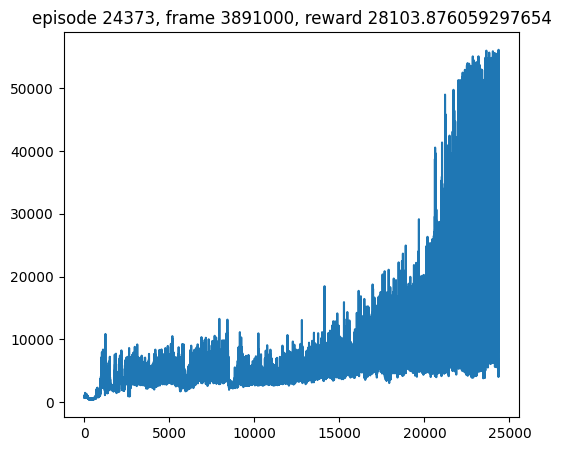

In [ ]:
frame_idx = 0 #중단시마다 업데이트

def f(episode_id: int) -> bool:
    if episode_id % 1000 == 0:
        return True
    else:
        return False

env = gym.make("Humanoid-v5", render_mode='rgb_array')
env = RecordVideo(env, video_folder="/content/drive/MyDrive/Colab Notebooks/gymnasium/humanoid_video", name_prefix=str(frame_idx),
                  episode_trigger=f)

action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]
hidden_dim = 512

value_net        = ValueNetwork(state_dim, hidden_dim).to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

soft_q_net = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

if os.path.exists('/content/drive/MyDrive/Colab Notebooks/gymnasium/humanoid_model/value_net_latest.pth'):
    value_net.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/gymnasium/humanoid_model/value_net_latest.pth'))
    soft_q_net.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/gymnasium/humanoid_model/soft_q_net_latest.pth'))
    policy_net.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/gymnasium/humanoid_model/policy_net_latest.pth'))
    target_value_net.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/gymnasium/humanoid_model/target_value_net_latest.pth'))
    print('model loaded')

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

value_criterion  = nn.MSELoss()
soft_q_criterion = nn.MSELoss()

value_lr  = 1e-5
soft_q_lr = 1e-5
policy_lr = 1e-5

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer = optim.Adam(soft_q_net.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

max_frames  = 10000000
episodes = 0
rewards     = []
batch_size  = 128

while frame_idx < max_frames:
    state,_ = env.reset()
    episode_reward = 0

    while True:
        action = policy_net.get_action(state)
        done = False
        next_state, reward, terminated, truncated, _ = env.step(action)
        reward *= 10
        if terminated or truncated:
            done = True
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            soft_q_update(batch_size)

        state = next_state
        episode_reward += reward
        frame_idx += 1

        if frame_idx % 1000 == 0:
            plot(episodes, frame_idx, rewards)
            if frame_idx % 100000 == 0:
                torch.save(value_net.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/gymnasium/humanoid_model/value_net_{frame_idx}.pth')
                torch.save(soft_q_net.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/gymnasium/humanoid_model/soft_q_net_{frame_idx}.pth')
                torch.save(policy_net.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/gymnasium/humanoid_model/policy_net_{frame_idx}.pth')
                torch.save(target_value_net.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/gymnasium/humanoid_model/target_value_net_{frame_idx}.pth')

                torch.save(value_net.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/gymnasium/humanoid_model/value_net_latest.pth')
                torch.save(soft_q_net.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/gymnasium/humanoid_model/soft_q_net_latest.pth')
                torch.save(policy_net.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/gymnasium/humanoid_model/policy_net_latest.pth')
                torch.save(target_value_net.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/gymnasium/humanoid_model/target_value_net_latest.pth')
        if done:
            episodes += 1
            break

    rewards.append(episode_reward)